# Creating an Ensemble Model

#### Marlena Bannick and Madeline McGaughey
##### *Institute for Health Metrics and Evaluation*

### Setup

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import pylab
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
np.random.seed(19404)

Load ensemble package

In [4]:
from ensemble.submodel import Submodel
from ensemble.ensemble import Ensemble
from ensemble import utilities

Load data from the data directory

In [5]:
workdir = '../data/'
data_frame = pd.read_csv(os.path.join(workdir, 'data.csv'))
cv_names = utilities.import_cv_vars(os.path.join(workdir, 'cv_selected.txt'))['rate_vars']

In [6]:
data_frame['ln_LDI_pc'] = np.log(data_frame['LDI_pc'])
data_frame['ln_omega_3_g_adj'] = np.log(data_frame['omega_3_g_adj'])
data_frame['ln_vegetables_g_adj'] = np.log(data_frame['vegetables_g_adj'])

### The Ensemble Story

#### *Our Purpose*

The goal of the Cause of Death Ensemble Model (CODEm) used in the Global Burden of Disease Study (GBD) is to synthesize all of the heterogeneous data sources from around the world to make the best, most comprehensive estimates for a specific cause of death.

In the absence of complete data, we need to use other information in the form of model covariates to help predict cause of death. Some diseases and injuries have variables with which they are strongly associated (e.g. prevalence of smoking is strongly associated with lung cancer death rate). In other cases, variables may have ambiguous, but plausible, associations with a certain cause of death. Response variables may also be best modeled with different functional forms depending on the cause of death, for example the log of the death rate versus the fraction of total deaths due to that cause.

As a motivating example and teaching exercise, we will use the approach of CODEm, in a simplified format, to predict as accurately as possible the mortality from ischemic heart disease in females in the United States from 1990-2005.

**More on CODEm**

You can find detailed methodology about CODEm [here](https://pophealthmetrics.biomedcentral.com/articles/10.1186/1478-7954-10-1). When we use an equation from this paper, we'll cite **Foreman et al 2012**.

The CODEm code that is used in production for the GBD Study each year is available at [this GitHub link]( https://github.com/ihmeuw/ihme-modeling/tree/master/shared_code/central_comp/cod/codem).

#### *The Data*

All of the data is publicly available for download from the following links:
- [Population data](http://ghdx.healthdata.org/record/ihme-data/gbd-2017-population-estimates-1950-2017)
- [All-cause mortality data](http://ghdx.healthdata.org/gbd-results-tool)
- [Cause-specific mortality data](https://vizhub.healthdata.org/cod/)
- [Covariate data](https://cloud.ihme.washington.edu/index.php/s/NEZgMdLQxpTziiP?path=%2FGBD%202017%20Covariates)

We have downloaded the data for all U.S. states, females, Ischemic Heart Disease, from 1990-2017. We have merged them together for one large dataset that is available in the repository [here](https://github.com/mbannick/simple-ensemble/tree/master/data/all_data.csv).

#### *The Non-Ensemble Modeling Approach*

##### Component Model Specification

One may consider many covariates that have a known or speculated association at the population-level with ischemic heart disease, including alcohol consumption, dietary risk factors, and overall socioeconomic development. Using some knowledge about these predictors, and adding a random effect for age (to account for variation in IHD mortality that is not captured by the covariates in the model), we can fit a mixed effects linear model on all of the available vital registration data for the United States. We will call a model like this a "component model": a statistical model that is used to predict a response variable.

We will use the `lme4::lmer` function from `R` (with `rpy2`) to fit this linear mixed effects model. The formal specification of this model is given by the following equation

\begin{align*}
y = X\beta + Z \upsilon + \epsilon
\end{align*}

where $y$ is a vector of the response variable in the model (e.g. death rate) with one entry for each location-year-age group, $X$ is a design matrix of covariates to predict the response (and column of 1's to specify an intercept), $\beta$ is a vector of fixed-effects, $Z$ is a vector specifying the group to which each observation belongs (in this case we are using age as the random effect), $\upsilon$ is a the error term around the random effect, and $\epsilon$ is a normally distributed, independent error, i.e. $\epsilon \sim N_n(0, \sigma^2)$ with $\sigma^2$ to be estimated (Foreman et al 2012).

The data frame has the following columns:

In [7]:
data_frame.columns

Index(['location', 'sex', 'age', 'year', 'pop', 'cause_fraction', 'LDI_pc',
       'SEV_scalar_IHD', 'alcohol_lpc', 'diabetes_fpg', 'fruits_g_adj', 'haqi',
       'mean_BMI', 'mean_SBP', 'mean_cholesterol', 'nuts_seeds_g_adj',
       'omega_3_g_adj', 'pollution_indoor_total_prev',
       'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'pufa_adj_pct',
       'pulses_legumes_g_adj', 'smoking_prev', 'tfa', 'vegetables_g_adj',
       'envelope', 'sdi', 'rate', 'ln_rate', 'lt_cf', 'ln_LDI_pc',
       'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
      dtype='object')

`location`, `sex`, `age`, and `year` are the demographic identifiers. `cause_fraction` is the fraction fo the deaths in that demographic group due to ischemic heart disease. `envelope` is the total number of deaths in that demographic group. `pop` is the total population in that demographic group. The other variables are covariates that we believe might be associated with the death rate due to ischemic heart disease.

Let's make a log rate variable, `ln_rate`. Predicting in log rate spaces is easier than predicting in cause fraction space, because the predictions can span the full real line.

In [8]:
data_frame['rate'] = data_frame['cause_fraction'].values * data_frame['envelope'].values / data_frame['pop'].values
data_frame['ln_rate'] = np.log(data_frame['rate'].values)

For a given set of covariates, age as a random effect, and the log of the death rate as our respnose, we have the following objects that we will use to fit our model. Let's pick one set of covariates to start with: mean cholesterol, Healthcare Access and Quality Index, outdoor pollution (measured in PM2.5), and the proportion of the population that lives at or above 1500 meters.

In [61]:
# create a list of covariate names
cv = ['mean_cholesterol', 'haqi', 'pollution_outdoor_pm25', 'pop_1500mplus_prop']

# subset the dataset to only the necessary columns
cols = ['location', 'age', 'year', 'ln_rate'] + cv
df = data_frame[cols]
df.head()

,location,age,year,ln_rate,mean_cholesterol,haqi,pollution_outdoor_pm25,pop_1500mplus_prop
0,Alabama,15 to 19,1990,-12.496447,5.342842,76.697596,11.072353,0.0
1,Alabama,20 to 24,1990,-12.053957,5.342842,76.697596,11.072353,0.0
2,Alabama,25 to 29,1990,-10.734324,5.342842,76.697596,11.072353,0.0
3,Alabama,30 to 34,1990,-10.725036,5.342842,76.697596,11.072353,0.0
4,Alabama,35 to 39,1990,-9.397679,5.342842,76.697596,11.072353,0.0


We have created an object class called `Submodel` that takes in all of the ingredients we need to fit this model and make our best predictions for heart disease mortality. Let's start by instantiating the component model that we want to use, and assigning it the attributes specific to this model. We can check out our new component model and look at its attributes that will be used to fit the model.

In [62]:
# create a Submodel object and retrieve its parameters
model = Submodel(response='ln_rate', fixed_effects=cv, random_effects=['age'])
model.get_params()

{'fixed_effects': ['mean_cholesterol',
  'haqi',
  'pollution_outdoor_pm25',
  'pop_1500mplus_prop'],
 'random_effects': ['age'],
 'response': 'ln_rate'}

In [63]:
# retrieve the model formula that will be used
model.formula

'ln_rate ~ + mean_cholesterol + haqi + pollution_outdoor_pm25 + pop_1500mplus_prop + (1|age) '

##### Single Component Model In-Sample Predictions

The `Submodel` class has functions to fit the model on a given dataset, and then predict on the same, or another dataset. Everytime we run `Submodel.fit()`, it will update the parameter estimates of the component model. Let's fit our model to the dataset and then predict on the same dataset.

In [64]:
# fit the component model to the dataset from above
model.fit(df)

Submodel(fixed_effects=['mean_cholesterol', 'haqi', 'pollution_outdoor_pm25', 'pop_1500mplus_prop'],
     random_effects=['age'], response='ln_rate')

In [13]:
# view the parameter estimates for the covariates
model.betas

array([-4.84910643e+00,  6.30904748e-05, -3.39661425e-02,  5.94550334e-02,
       -4.28516385e-02])

In [14]:
# view the predictions for the model
predictions = model.predict(df)
predictions

array([-12.25712175, -11.51390757, -10.82696033, ...,  -3.7875881 ,
        -3.20184673,  -2.5018255 ])

In [15]:
model.rmse(df)

0.23907513422501608

We can judge the quality of our predictions by looking at a metric that captures the average squared deviation of the prediction from the data, a called root mean squared error. With $\hat{y}_i$ and $y_i$ as the prediction and raw data for observation $i$ out of $n$ observations, RMSE is calculated as follows:

\begin{align*}
RMSE = \sqrt{\frac{1}{n}\sum_{i=1}^n (\hat{y}_i - y_i)^2}
\end{align*}

Using the `rmse` function in the `Submodel` class, we can calculate the RMSE for the predictions that we just made.

To get another view of the predictions, we can plot the predictions for a few age-locations over time. We will look at Washington, for age groups 60-64, 65-69, 70-74, 75-79, and 80-84 from 1990-2005. We can see in the plot below that our predictions are capturing the overall trend of the data, but it's not doing as well as we might expect. You can see the effect of age, that adding a random effect just increases or decreases the intercept, but the shape of the line doesn't change.

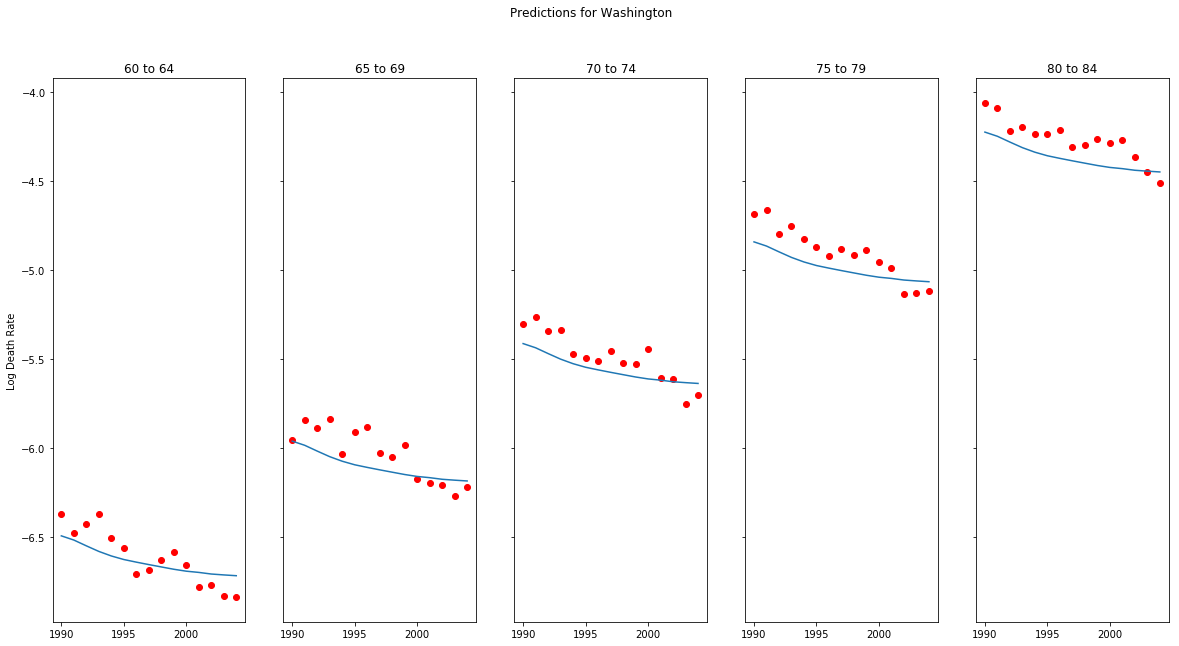

In [16]:
model.plot_predictions(df, querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

What if other covariates could do a better job than the ones that we have pre-specified as being associated with heart disease mortality? Could we include more covariates in the model to make our predictions better? Let's try putting in a whole bunch of covariates that could be associated with heart disease mortality.

In [17]:
# create a list of covariate names
cv = ['alcohol_lpc', 'diabetes_fpg', 'mean_BMI', 'mean_cholesterol', 'mean_SBP', 'pollution_indoor_total_prev', 'pollution_outdoor_pm25',
      'pop_1500mplus_prop', 'smoking_prev', 'SEV_scalar_IHD', 'sdi', 'fruits_g_adj',
      'nuts_seeds_g_adj', 'pufa_adj_pct', 'pulses_legumes_g_adj', 'haqi', 'tfa', 'ln_LDI_pc', 'ln_omega_3_g_adj', 'ln_vegetables_g_adj']

In [18]:
# create a Submodel object and retrieve its parameters
model = Submodel(response='ln_rate', fixed_effects=cv, random_effects=['age'])

In [19]:
data_frame.columns

Index(['location', 'sex', 'age', 'year', 'pop', 'cause_fraction', 'LDI_pc',
       'SEV_scalar_IHD', 'alcohol_lpc', 'diabetes_fpg', 'fruits_g_adj', 'haqi',
       'mean_BMI', 'mean_SBP', 'mean_cholesterol', 'nuts_seeds_g_adj',
       'omega_3_g_adj', 'pollution_indoor_total_prev',
       'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'pufa_adj_pct',
       'pulses_legumes_g_adj', 'smoking_prev', 'tfa', 'vegetables_g_adj',
       'envelope', 'sdi', 'rate', 'ln_rate', 'lt_cf', 'ln_LDI_pc',
       'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
      dtype='object')

In [20]:
# subset the dataset to only the necessary columns
cols = ['location', 'age', 'year', 'ln_rate'] + cv
df = data_frame[cols]
model.fit(df)

Submodel(fixed_effects=['alcohol_lpc', 'diabetes_fpg', 'mean_BMI', 'mean_cholesterol', 'mean_SBP', 'pollution_indoor_total_prev', 'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'smoking_prev', 'SEV_scalar_IHD', 'sdi', 'fruits_g_adj', 'nuts_seeds_g_adj', 'pufa_adj_pct', 'pulses_legumes_g_adj', 'haqi', 'tfa', 'ln_LDI_pc', 'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
     random_effects=['age'], response='ln_rate')

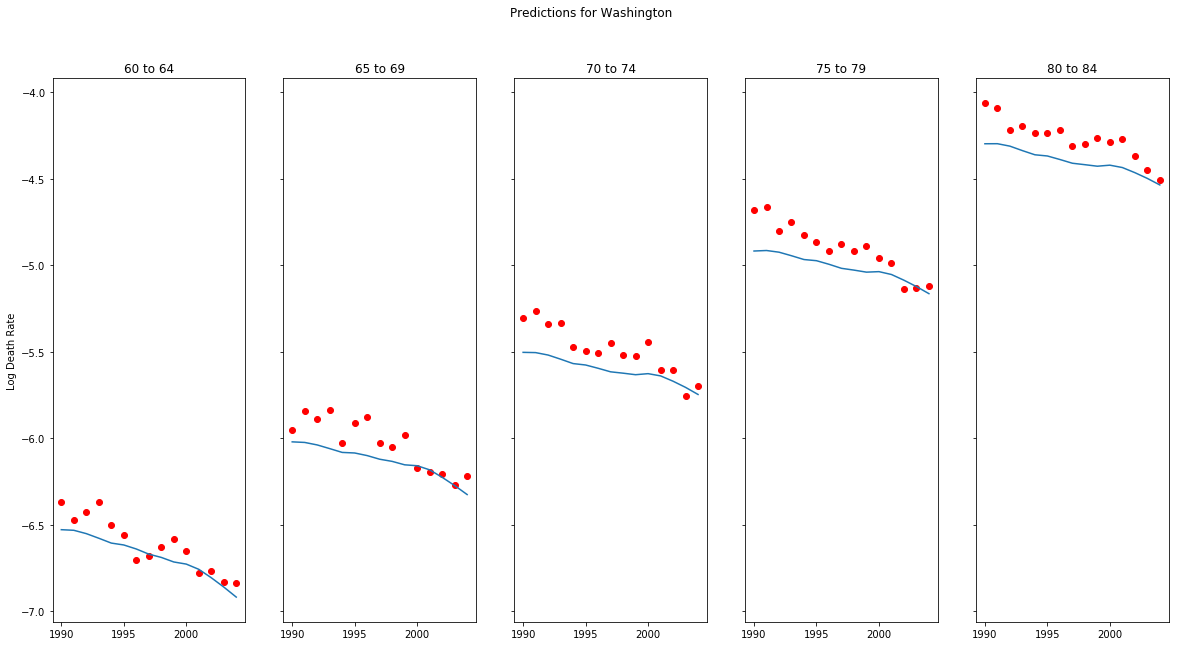

In [21]:
model.plot_predictions(df, querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

In [22]:
model.rmse(df)

0.21545665378404902

##### Single Component Model Out-of-Sample Predictions

It looks like the model is doing a bit better with added covariates, but can we make it better? We could continue adding more and more covariates and random effects to make our RMSE smaller, we may **over-fit** the model to our data. Over-fitting is what happens when we get really good predictions for the data that we used to fit the model but terrible predictions for data that was hidden from the model.

When assessing model performance, we really want to know about out-of-sample performance. We don't want our model to just be good at predicting the data points that were used in the fitting process. We want the model to be able to accurately predict heart disease mortality in places that *don't* have data based on the relationships that exist in places with data. In reality, datasets are not complete.

How can we simulate performance in places without data? We can remove whole groups of locations at a time, train the model on the places with data, and then see how well we do predicting for places where we've removed data. To do this, we will use a **random knockout process** that leaves out whole groups at a time from `scikit-learn` called `GroupShuffleSplit`. Let's run `GroupShuffleSplit` on our data frame **once** to split the data frame into a training and test set, leaving out full location time-series. We will default to using 70% of the data to train the model and 30% of the data to test the model.

In [23]:
train_list, test_list = utilities.split_groups(data_frame, n_splits=1, test_size=0.3, groups='location')

In [24]:
# fit the model on the training set and predict on the test set
model.fit(train_list[0])

Submodel(fixed_effects=['alcohol_lpc', 'diabetes_fpg', 'mean_BMI', 'mean_cholesterol', 'mean_SBP', 'pollution_indoor_total_prev', 'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'smoking_prev', 'SEV_scalar_IHD', 'sdi', 'fruits_g_adj', 'nuts_seeds_g_adj', 'pufa_adj_pct', 'pulses_legumes_g_adj', 'haqi', 'tfa', 'ln_LDI_pc', 'ln_omega_3_g_adj', 'ln_vegetables_g_adj'],
     random_effects=['age'], response='ln_rate')

In [25]:
model.rmse(train_list[0])

0.21048223617146203

In [26]:
model.rmse(test_list[0])

0.23774787205920578

#### *The Ensemble Modeling Approach*

How can we construct a model that get's **better** out-of-sample performance? Ensemble modeling is the approach that we take use CODEm for the GBD Study (Foreman et al 2012). There are various ways to construct an ensemble model, and some commonly known strategies have names like "boosting", and "random forests". For this teaching exercise, we will construct an ensemble model by thinking about lots of different classifiers that might be able to predict heart disease mortality, and then finding a smart way to combine the models in order to get the best predictions possible. We have created an object class called `Ensemble` that takes a list of component models, and then provides wrapper functions to the component model functions like `Submodel.fit()`. In the next section, we will discuss one way to create that list of component models.

##### Creating Component Models with Feature Selection

CODEm performs feature selection to determine which covariates to use. Commonly, feature selection involves modeling techniques such as the lasso, ridge regression, or forward/backward selection. These strategies result in a set of features, or covariates, that have been selected as "good" predictors of the outcome variable of interest. In the CODEm approach, modelers specify covariates that they think could be potentially associated with a cause of death, in this case heart disease mortality in females, like we did above. The modelers specify a degree of how associated a covariate is with heart disease. Level 1 covariates are covariates with strong biological associations with heart disease mortality. Level 2 and 3 covariates are more distantly related covariates. For this model, the modeler pre-specified the following covariates:

**Level 1**
* Mean cholesterol
* Mean systolic blood pressure
* Smoking prevalence
* SEV scalar (summary measure of risk exposure)

**Level 2**
* Prevalence of indoor pollution
* Prevalence of outdoor pollution (PM 2.5)
* Diabetes fasting plasma glucose
* Mean BMI
* Proportion of population living at 1500+ m
* Healthcare Access and Quality Index

**Level 3**
* Alcohol liters per capita consumed
* Lagged-Distributed Income per capita
* Avg. Omega-3 grams consumed
* Avg. Fruits grams consumed
* Avg. Nuts and seeds grams consumed
* Avg. Polyunsaturated fat grams consumed
* Avg. Pulses and legumes grams consumed
* Avg. Vegetables grams consumed
* Diet high in trans fatty acids

Then, the modeler specifies which direction the correlation should be in. For example, they would say that smoking should be positively correlated with heart disease mortality, and that fruit consumed should be negatively correlated with mortality. Or they can specify no prior direction. CODEm then tests each level 1 covariate independently with the outcome of interest and makes sure that it is both significant at the p=0.05 level and that the direction of the relationship matches what the modeler had as their prior belief (if it existed). If these match up, then combinations of level 1 covariates are similarly tested. CODEm then moves on to adding level 2 covariates one by one onto the level 1 classifiers to create another set of classifiers, and finishes with level 3. We have not replicated the feature selection here, but have loaded the result of the feature selection process so that we have a list of classifiers based on significant combinations of covariates. More details on covariate selection are available in [Foreman et al 2012](https://pophealthmetrics.biomedcentral.com/articles/10.1186/1478-7954-10-1).

In [27]:
# total number of classifiers/submodels
len(cv_names)

172

In [28]:
# look at a subset of the classifier fixed effects
cv_names[1:10]

[['mean_SBP'],
 ['SEV_scalar_IHD'],
 ['smoking_prev'],
 ['mean_cholesterol', 'SEV_scalar_IHD'],
 ['mean_cholesterol', 'smoking_prev'],
 ['mean_SBP', 'SEV_scalar_IHD'],
 ['mean_SBP', 'smoking_prev'],
 ['SEV_scalar_IHD', 'smoking_prev'],
 ['mean_SBP', 'SEV_scalar_IHD', 'smoking_prev']]

##### Constructing an Ensemble

Let's first create a list of component models based on the result of feature selection, using the log of the mortality rate (`ln_rate`) as our response variable. We'll use `classifiers` as the name for our list of component models.

In [29]:
classifiers = [Submodel(response='ln_rate', fixed_effects=cv, random_effects=['age']) for cv in cv_names]

Now we can create an ensemble object with the list of classifiers, and view the properties of the classifiers in the ensemble.

In [30]:
ensemble = Ensemble(classifiers)

In [31]:
# view the first several classifiers' parameters
ensemble.get_classifier_params()[1:5]

[{'fixed_effects': ['mean_SBP'],
  'random_effects': ['age'],
  'response': 'ln_rate'},
 {'fixed_effects': ['SEV_scalar_IHD'],
  'random_effects': ['age'],
  'response': 'ln_rate'},
 {'fixed_effects': ['smoking_prev'],
  'random_effects': ['age'],
  'response': 'ln_rate'},
 {'fixed_effects': ['mean_cholesterol', 'SEV_scalar_IHD'],
  'random_effects': ['age'],
  'response': 'ln_rate'}]

We need some way to combine the predictions from each of the component models. We will use RMSE, defined in the previous section, as a **metric for how well each of the component models does** at predicting heart disease mortality. Component models with a lower RMSE are doing *better* at predicting. We can now rank the component models based on their RMSE, with component model #1 having the smallest RMSE, and then define a weighting scheme that converts the ranks to weights to be applied to each of the ensembles. We introduce a hyper-parameter, $\psi$, that determines how quickly these weights decline. For example, a $\psi = 1$ will have more evenly distributed weights, and a $\psi = 1.5$ will have relatively less evenly distributed weights. See the figure [here](https://pophealthmetrics.biomedcentral.com/articles/10.1186/1478-7954-10-1#Fig2) for an illustration of how the weights decline for varying $\psi$. Let the weight for the $i^{th}$ component model out of $N$ total component models be given by

\begin{align*}
w_i = \frac{\psi^{N-rank_i}}{\sum_{j=1}^{n} \psi^{N-j}}
\end{align*}

where the $\sum_{i=1}^n w_i = 1$ (more details in [Foreman et al 2012](https://pophealthmetrics.biomedcentral.com/articles/10.1186/1478-7954-10-1)).

We will now rank the submodels from their out-of-sample performance on the training-test sets that we had before for the single component model, and assign them weights based on $\psi = 1.2$.

In [32]:
ensemble.rank(trainings=train_list, tests=test_list)

Let's look at the ranks for each of the classifiers:

In [33]:
ensemble.ranks

array([130.,  94., 117., 143., 118., 142.,  90., 110., 156., 155.,  82.,
        80., 154.,  81.,  70.,  73., 103.,  54.,  64.,  50., 107.,  52.,
       153.,  71.,  78.,  56.,  51., 148., 152.,  72.,  41., 120., 134.,
       139., 123., 144.,  55.,  34.,  24.,  38.,  45.,  27.,  28., 124.,
       113., 127., 137., 140., 131., 132., 141., 149., 151., 147., 112.,
       121., 114., 116., 145., 138., 162., 146., 150.,  48.,  19.,  22.,
        30.,  10.,   8.,  29.,  95., 163., 164.,  75., 126., 119., 136.,
       135.,   6.,  88., 115.,  16.,   5.,  62.,  68., 172., 165.,  77.,
        79., 102., 166., 167.,  12.,   7.,   9.,  11.,  17.,  13.,  20.,
       111.,  57.,  60.,  61.,  65.,  74.,  67.,  84.,  63.,  58.,  87.,
       100.,  99., 104., 169.,  46.,  35.,  53.,  42.,  40.,  44.,  83.,
        98., 170., 109., 108., 101., 105., 106.,  69., 160., 159.,  66.,
        37., 168.,  43.,  31.,   2.,   1.,   4.,   3.,  15.,  89.,  85.,
        59.,  26.,  76.,  33.,  49., 161.,  36.,  4

In [37]:
len(ensemble.classifiers)

172

##### Generating Draws for Uncertainty

In order to get the final ensemble predictions, we want to capture the uncertainty from each submodel and also heterogeneity across submodels. We take $1000 \cdot w_i$ number of draws from component model $i$ by sampling from the variance-covariance matrix of the parameters and random effect. Thus if we have:

\begin{align*}
\hat{\beta} \sim N_{p+1}(\beta, \Sigma)
\end{align*}

where $p$ is the number of features in the component model and $\Sigma$ is the variance-covariance matrix of $\hat{\beta}$, we can take one realization of this multivariate normal distribution, and treat it as if it were the parameter estimates that we got from the `lmer` object. Because $\hat{\beta}$ is a random variable, multiple draws from the distribution will approximate this uncertainty. We can similarly take a draw from the random effects with $\hat{\upsilon} \sim N_r(\upsilon, \hat{\epsilon})$ and add that on to the prediction. In this case, we have 1000 draws total for the ensemble, with $1000*w_i$ draws from component model $i$. Each draw is given by:

\begin{align*}
\hat{y}_{j_i} = X\hat{\beta}_{j_i} + Z\hat{\upsilon}_{j_i}
\end{align*}

We take the mean of all 1000 $\hat{y}_{j_i}$ to get our final $\hat{y}$. A 95% confidence interval is then given by the 2.75th and 97.5th percentiles of the 1000 draws. Here we will generate 1000 draws from the ensemble that we've created with the function `Ensemble.combine()`.

In [38]:
ensemble.combine(df=data_frame, n_draws=1000, psi=1.2)

Let's look at our predictions now for this ensemble compared to the raw data.

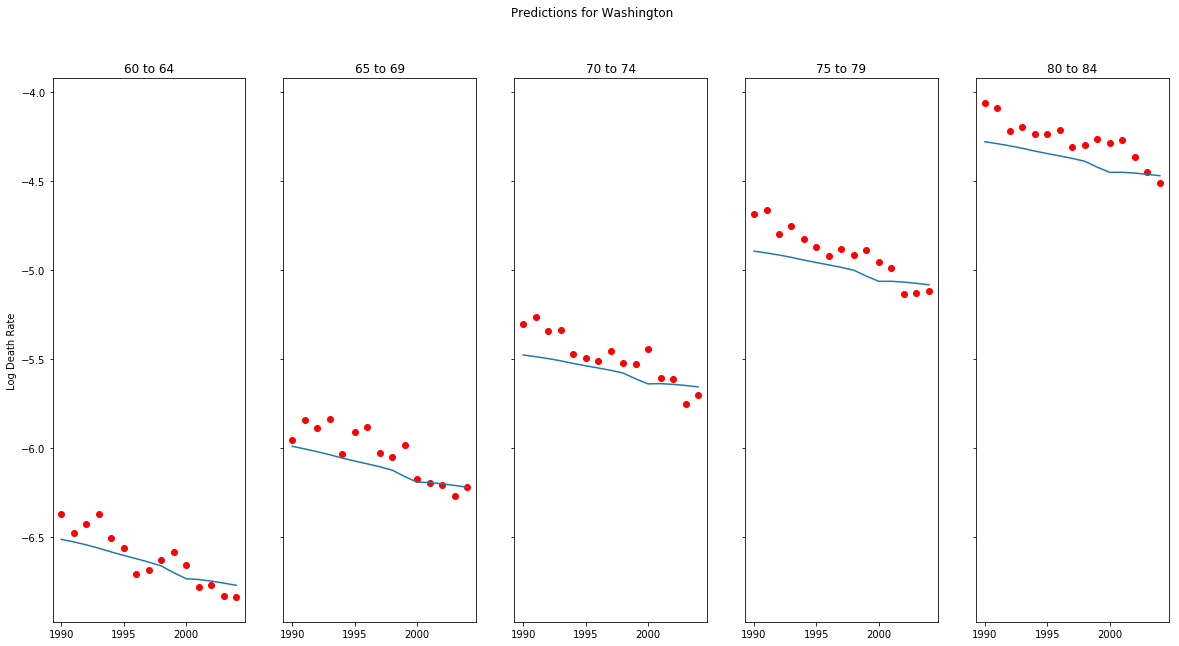

In [39]:
ensemble.plot_predictions(data_frame, response='ln_rate', querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

In [40]:
# RMSE for overall ensemble on full dataset
ensemble.get_rmse([data_frame], n_draws=1000, response='ln_rate', refit=False)
ensemble.rmse

0.22884912537057614

##### Get Better Ensemble Predictions

To get better out-of-sample predictions, we will make multiple training-test sets. In this case, we rank submodels based on their **average OOS RMSE**. We can do this again with `GroupShuffleSplit`, and then `Ensemble.rank()` will rank component models for a whole list of training-test pairs.

In [41]:
train_list, test_list = utilities.split_groups(data_frame, n_splits=10, test_size=0.3, groups='location')

In [42]:
# fit the model on the training set and predict on the test set
ensemble = Ensemble(classifiers)
ensemble.rank(train_list, test_list)

In [43]:
ensemble.combine(data_frame, n_draws=1000, psi=1.2, refit=False)

Our final predictions would be given the refitting the dataset, but with the combination of component models that we chose to have best OOS predictive validity, so we can be sure that we're not over-fitting the data, and are making the best predictions that we can in the absence of data.

In [44]:
ensemble.get_rmse([data_frame], n_draws=1000, response='ln_rate', refit=False)
ensemble.rmse

0.23119052178136043

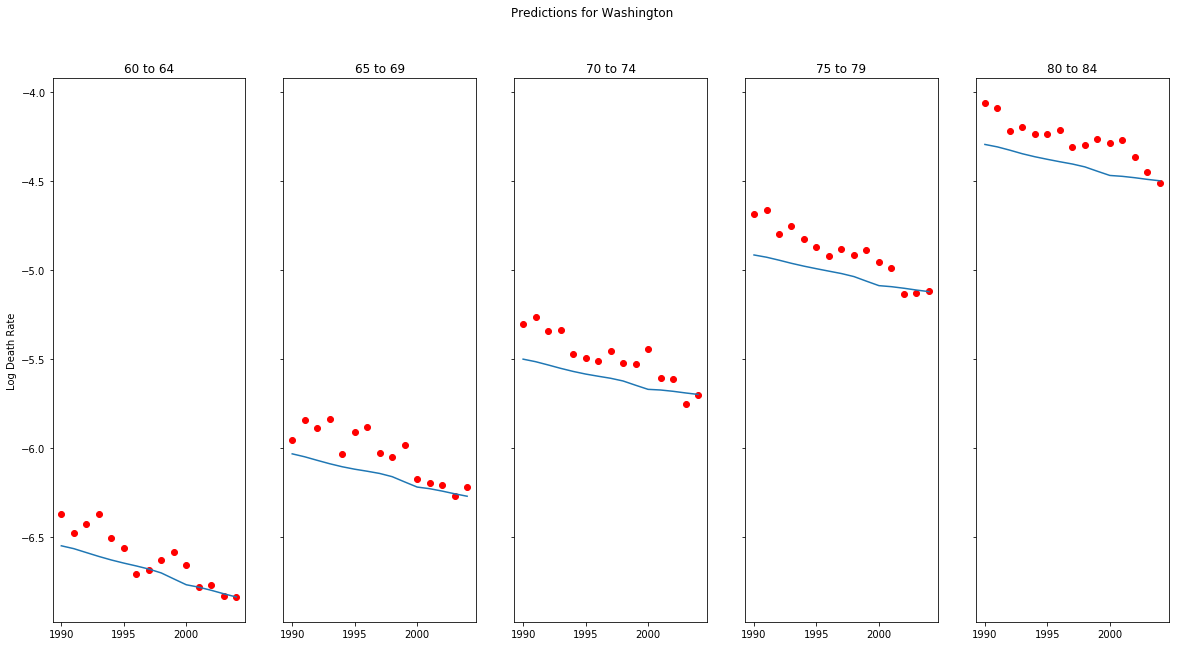

In [45]:
ensemble.plot_predictions(data_frame, response='ln_rate', querystring='location == "Washington"',
                       ages=['60 to 64', '65 to 69', '70 to 74', '75 to 79', '80 to 84'])

##### Why we use ensembles: compare the ensemble RMSE to the **BEST** classifier RMSE

In order to make a fair comparison of our ensemble to the best submodel, we need to make sure they are evaluated on the **same amount of training and test data**. Because the ensemble actually uses the performance of the submodel on the 30% of test data to optimally rank the submodels, it would not be accurate to look at its performance on the test set.

Instead we will create multiple sets of training-test1-test2, where each test set has 15% of the data, and the training has 70%. Then the component models in the ensemble will be fit on 70% of the data, tested for the ranks on 15% of the data, and then RMSE for the entire ensemble evaluated on the last 15% of the data that it hasn't seen yet. We will then train the best submodel from the ensemble on 85% of the data made up of training and test1, and then test its performance on the same 15% of the data that the ensemble is evaluated on. This way, both the ensemble and the best submodel see the same 85% of the data, and are evaluated on the same 15% of the data, across multiple knockouts.

First, let's create the 70-30 split:

In [46]:
train_list, test_list = utilities.split_groups(data_frame, n_splits=10, test_size=0.3, groups='location')

Now let's split each test dataframe into one list of 50-50, test1 and test2.

In [47]:
test1_list = []
test2_list = []
for test in test_list:
    test1, test2 = utilities.split_groups(test, n_splits=1, test_size=0.5, groups='location')
    test1_list.append(test1[0])
    test2_list.append(test2[0])

And we want to use training + test1 to create a list for the best submodel to be trained on.

In [48]:
submodel_train_list = []
for test, train1 in zip(train_list, test1_list):
    submodel_train_list.append(pd.concat([test, train1]))

Let's construct our ensemble on the test and train 1 set, and then get the average RMSE for test2 across all knockouts:

In [49]:
ensemble = Ensemble(classifiers)
ensemble.rank(train_list, test1_list)

In [50]:
ensemble.ranks

array([ 47.,  32., 136., 135.,  38.,  45.,  18.,  24., 134., 133.,   9.,
       132., 131.,   4., 130., 129., 128., 127., 126., 125., 124., 123.,
       137., 122., 120., 119., 118., 117.,   3., 116., 115., 114.,  42.,
        44.,  43., 113.,  25., 112.,  21.,  19., 111.,  23.,  22.,  37.,
        20.,  41.,  40., 110., 109.,  39.,  29., 108.,  46.,  36.,  30.,
        27.,  28.,  33.,  34.,  26.,  31.,  35., 107., 121., 139.,  11.,
       155., 140., 170.,  10.,  12., 169., 168., 167., 166., 165., 164.,
        14., 163., 162., 161., 160., 159., 158., 157., 105., 156., 154.,
       153., 152., 151., 150., 149., 148., 147., 146.,   7., 145., 144.,
       143., 142., 141., 106., 138., 104.,  99.,  54.,  55.,  56.,   5.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,   6.,  69.,  52.,  70.,  53.,   8.,  71.,  49.,  48.,  51.,
        50.,  72.,  88.,   1.,   2.,  74., 102., 101., 100.,  73.,  98.,
        97.,  96.,  95.,  94.,  93.,  92.,  91.,  9

In [51]:
ensemble.get_rmse(test2_list, n_draws=1000, response='ln_rate', psi=1.2, refit=False)

In [52]:
ensemble.ranks.tolist().index(1)

135

In [53]:
ensemble.rmse

0.21239420175999366

Now we will switch to using the component model train list and the test2 to evaluate the best submodel. We can find the best submodel by pulling it from the ensemble ranks.

In [55]:
ensemble = Ensemble(classifiers)
ensemble.rank(submodel_train_list, test2_list)
best_index = ensemble.ranks.tolist().index(1)
best_classifier = classifiers[best_index]

In [56]:
best_classifier

Submodel(fixed_effects=['mean_SBP', 'SEV_scalar_IHD', 'pollution_indoor_total_prev', 'pollution_outdoor_pm25', 'pop_1500mplus_prop', 'ln_omega_3_g_adj', 'sdi'],
     random_effects=['age'], response='ln_rate')

How does this component model do in terms of RMSE when it has access to 85% of the data, across all knockouts?

In [57]:
best_classifier.rmse_mean(submodel_train_list, test2_list)

0.22346606917973905

Indeed, the ensemble is better than the best component model in terms of out-of-sample RMSE!